## Functional annotation

This notebook was made for generic annotation of contigs. Basically, it assumes that you have:

1. A fasta file with aminoacid sequences (you database). If you have DNA, you can produce the aminoacid sequences with `transeq` from the EMBOSS package (or consider blasting the DNA sequences directly).
2. A fasta file with the sequences you want to annotate (your query).
3. A count table with abundances of the sequences you want to annotate.

## How to run Jupyter notebooks in huginn
<details>
<summary>Click to expand!</summary>

If you use vs-code you can use the [remote ssh extension](https://marketplace.visualstudio.com/items?itemName=ms-vscode-remote.remote-ssh) to connect to huginn and either run jupyterlab in the remote server (so to say, just like you would do in your local computer with `jupyter-lab`) or run directly without opening jupyterlab directly. 

Otherwise, you can follow the instructions below: 

1. Turn on VPN
2. Open two terminals (let's called A and B)
3. With terminal A, connect to huginn with ssh as usual
```bash
ssh username@huginn.au.dk
```
4. Move to the directory where you want to work, activate the conda enviroment and run jupyter notebook or jupyter lab:
```bash
conda activate jupyter-diamond
jupyter notebook --no-browser --port=7777
```
5. With terminal B, connect to huginn and forward the port specified port to your local computer
```bash
ssh -Y -N -L localhost:7777:localhost:7777 username@huginn.au.dk
```
6. Open your browser and go to `localhost:7777` and you should see the jupyter notebook running in huginn. You can also press in the url of Terminal A. 

Troubleshooting:
- If you get an error like `bind: Address already in use` it means that you have another jupyter notebook running in the same port. You can either kill the process or change the port.
</details>

## How to create a new environment for this notebook (if needed)

We will use Diamond, a few python basic libraries and bash. Let's check if those dependencies are installed. If not, you can install them with mamba (as well with jupyterlab)

```bash
# To create a new environment with mamba
mamba create -c bioconda -c conda-forge diamond pandas matplotlib jupyterlab -n jupyter-diamond
# To activate the environment
conda activate jupyter-diamond
```

### Sanity check

In [1]:
%%bash
diamond --version
python -c "import pandas; print(pandas.__version__)"
python -c "import matplotlib; print(matplotlib.__version__)"
bash --version | head -n 1

diamond version 2.1.8
1.1.5
3.3.4
GNU bash, version 4.4.20(1)-release (x86_64-pc-linux-gnu)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

The input is the fasta file with contigs and the count table. 

In [3]:
database_file = "../data/database.fasta"
out_database_file = "../data/database.dmnd"
query_file = "../data/contigs.fasta"
count_table = "../data/mapped_reads_to_contigs.tsv"
## Sanity check: query, database and count table exit
assert os.path.exists(database_file)
assert os.path.exists(query_file)
assert os.path.exists(count_table)

## Build the database
First, we need to build the database. If you are using the generic notebook, chances are that the database is rather small and you can build it every time you run the notebook. If you are using a large database, you might want to build it once and use it multiple times. 

In [4]:
%%bash -s "$database_file" "$out_database_file"
if [ ! -f $2 ]; then
    diamond makedb --in $1 -d $2
fi

## Run Diamond 

In [5]:
outfile_matches = "../results/generic_matches.tsv"

**Please, be aware that, without using any sensitivity option, the default mode is designed for finding hits of >60% identity. Consider increasing the sensitivity (or decreasing it).**

In [6]:
%%bash -s "$out_database_file" "$query_file" "$outfile_matches"
if [ ! -f $3 ]; then
mkdir -p $(dirname $3)
diamond blastx -p 50 -d $1 -q $2 -o $3 2> /dev/null
fi
head $3

TRINITY_DN226500_c0_g1_i1	Dummy1	100	70	0	0	1	210	1	70	1.17e-58	159


## Parse Diamond output and preprocess

In [7]:
diamond = pd.read_csv(
    outfile_matches,
    delimiter="\t",
    comment="#",
    header=None,
    names=[
        "Query id",
        "Subject id",
        "% identity",
        "alignment length",
        "mismatches",
        "gap openings",
        "q. start",
        "q. end",
        "s. start",
        "s. end",
        "e-value",
        "score",
    ],
)

Now, we have a table with all the alignments between our "genes" and the database.

In [8]:
diamond

,Query id,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
0,TRINITY_DN226500_c0_g1_i1,Dummy1,100,70,0,0,1,210,1,70,1.170000e-58,159


## Read count table
However, we also need to read the count table:

In [9]:
%%bash -s "$count_table"
head $1

ContigID	SampleA	SampleB	SampleC	SampleD	SampleE
TRINITY_DN226500_c0_g1_i1	0	0	2	1	0
TRINITY_DN226510_c0_g1_i1	1	0	0	0	5
TRINITY_DN226477_c0_g1_i1	0	0	0	0	0
TRINITY_DN226449_c0_g1_i1	0	0	2	0	0
TRINITY_DN226457_c0_g1_i1	3	6	0	0	0
TRINITY_DN226454_c0_g1_i1	0	0	0	9	0
TRINITY_DN226455_c0_g1_i1	0	2	0	0	2
TRINITY_DN2264898_c0_g1_i1	0	2	1	1	2
TRINITY_DN78676876898_c0_g1_i1	0	2	1	1	20

In [10]:
counts = pd.read_csv(count_table, sep="\t", comment="#").set_index("ContigID")
counts

,SampleA,SampleB,SampleC,SampleD,SampleE
ContigID,,,,,
TRINITY_DN226500_c0_g1_i1,0,0,2,1,0
TRINITY_DN226510_c0_g1_i1,1,0,0,0,5
TRINITY_DN226477_c0_g1_i1,0,0,0,0,0
TRINITY_DN226449_c0_g1_i1,0,0,2,0,0
TRINITY_DN226457_c0_g1_i1,3,6,0,0,0
TRINITY_DN226454_c0_g1_i1,0,0,0,9,0
TRINITY_DN226455_c0_g1_i1,0,2,0,0,2
TRINITY_DN2264898_c0_g1_i1,0,2,1,1,2
TRINITY_DN78676876898_c0_g1_i1,0,2,1,1,20


## Preprocessing
### Most significant hit per Contig

Now, we need to get the most significant hit per each contig ID. Let's inspect how many hits there are per contig (adjust the number of bins). 

Text(0.5, 1.0, 'Number of hits per contig')

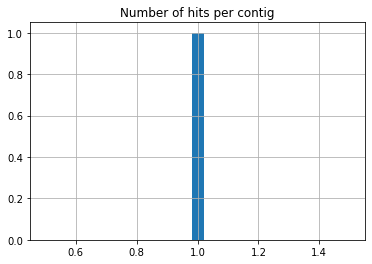

In [11]:
diamond.pivot_table(columns=["Query id"], aggfunc="size").hist(bins=25)
plt.title("Number of hits per contig")

In this case, we are going to sort rows per e-value and score and get the most significant hit per each ContigId.

In [12]:
diamond = (
    diamond.sort_values(by=["e-value", "score"], ascending=[True, False])
    .drop_duplicates("Query id", keep="first")
    .set_index("Query id")
)
diamond

,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
Query id,,,,,,,,,,,
TRINITY_DN226500_c0_g1_i1,Dummy1,100,70,0,0,1,210,1,70,1.170000e-58,159


### Inspect E-values from aligned orthologous genes before filtering by e-value

array([[<AxesSubplot:title={'center':'e-value'}>]], dtype=object)

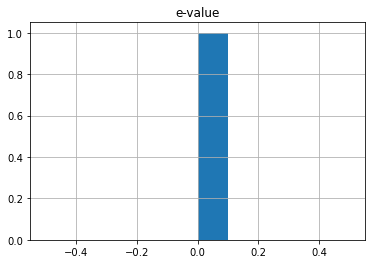

In [13]:
diamond.hist("e-value")

### Inspect E-values from aligned orthologous genes after filtering by e-value

We need to set a threshold:

In [14]:
evalue_threshold = 0.0001

In [15]:
diamond = diamond.loc[diamond["e-value"] < evalue_threshold]

array([[<AxesSubplot:title={'center':'e-value'}>]], dtype=object)

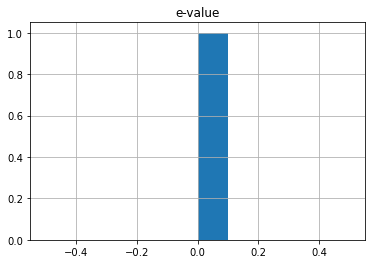

In [16]:
diamond.hist("e-value")

In [17]:
val = len(set(diamond["Subject id"]))
print(f"There are {val} unique orthologous genes")

There are 1 unique orthologous genes


### Inspect % identity and aligment length

array([[<AxesSubplot:title={'center':'alignment length'}>]], dtype=object)

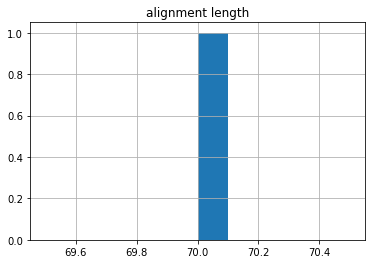

In [18]:
diamond.hist("alignment length")

array([[<AxesSubplot:title={'center':'% identity'}>]], dtype=object)

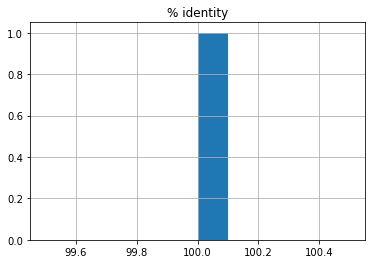

In [19]:
diamond.hist("% identity")

In [20]:
diamond

,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
Query id,,,,,,,,,,,
TRINITY_DN226500_c0_g1_i1,Dummy1,100,70,0,0,1,210,1,70,1.170000e-58,159


Text(0, 0.5, 'Mistmatches')

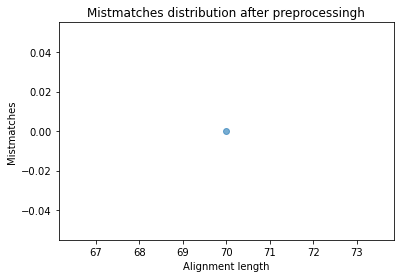

In [21]:
plt.scatter(diamond["alignment length"], diamond.mismatches, alpha=0.6)
plt.title("Mistmatches distribution after preprocessingh")
plt.xlabel("Alignment length")
plt.ylabel("Mistmatches")

## Attention !!
Please, consider the previous information to set the threshold for the e-value and the % identity.

### Merging aligned genes and count table
First, we are going to drop all columns except for ContigsID and orthologous genes header (to obtain map table). 

In [22]:
map_table = diamond[["Subject id"]]
map_table

,Subject id
Query id,
TRINITY_DN226500_c0_g1_i1,Dummy1


Now, we are going to merge both files by their column in common (ContigID and Subject id).

In [23]:
df = pd.merge(map_table, counts, left_index=True, right_index=True).reset_index(
    drop=True
)
df

,Subject id,SampleA,SampleB,SampleC,SampleD,SampleE
0,Dummy1,0,0,2,1,0


### Aggregate table
Now, we are going to aggregate the rows by grouping by "Subject id" (notice the difference in rows between the previous table and the following):

In [24]:
df = df.groupby("Subject id").sum(numeric_only=True).reset_index()
df

,Subject id,SampleA,SampleB,SampleC,SampleD,SampleE
0,Dummy1,0,0,2,1,0


## Annotating count table

Unfortunately, we can't annotate your generic database. But you can add you own code here:

In [25]:
# Very clever stuff
df["Annotation"] = ["foo" for _ in range(df.shape[0])]
df

,Subject id,SampleA,SampleB,SampleC,SampleD,SampleE,Annotation
0,Dummy1,0,0,2,1,0,foo


And you may also want to aggregate counts by that annotation:

In [26]:
df = df.groupby("Annotation").sum(numeric_only=True)
df

,SampleA,SampleB,SampleC,SampleD,SampleE
Annotation,,,,,
foo,0,0,2,1,0


In [27]:
df.to_csv("../results/generic_matches_annotated.tsv", sep="\t")